In [1]:
import findspark
findspark.init("/usr/local/spark/spark-2.2.1-bin-hadoop2.7")

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('MarvelCinematicUniverse').getOrCreate()

In [3]:
book = spark.read.text('Books.txt')
character = spark.read.text('Characters.txt')
edges = spark.read.text('Edges.txt')

In [4]:
book.take(10)

[Row(value='Vertex 6487: AA2 35'),
 Row(value='Vertex 6488: M/PRM 35'),
 Row(value='Vertex 6489: M/PRM 36'),
 Row(value='Vertex 6490: M/PRM 37'),
 Row(value='Vertex 6491: WI? 9'),
 Row(value='Vertex 6492: AVF 4'),
 Row(value='Vertex 6493: AVF 5'),
 Row(value='Vertex 6494: H2 251'),
 Row(value='Vertex 6495: H2 252'),
 Row(value='Vertex 6496: COC 1')]

In [5]:
character.take(10)

[Row(value='Vertex 1: 24-HOUR MAN/EMMANUEL'),
 Row(value='Vertex 2: 3-D MAN/CHARLES CHANDLER & HAROLD CHANDLER'),
 Row(value='Vertex 3: 4-D MAN/MERCURIO'),
 Row(value='Vertex 4: 8-BALL/'),
 Row(value='Vertex 5: A'),
 Row(value="Vertex 6: A'YIN"),
 Row(value='Vertex 7: ABBOTT, JACK'),
 Row(value='Vertex 8: ABCISSA'),
 Row(value='Vertex 9: ABEL'),
 Row(value='Vertex 10: ABOMINATION/EMIL BLONSKY')]

In [6]:
edges.take(10)

[Row(value='*Vertices 19428 6486'),
 Row(value='1 "24-HOUR MAN/EMMANUEL"'),
 Row(value='2 "3-D MAN/CHARLES CHAN"'),
 Row(value='3 "4-D MAN/MERCURIO"'),
 Row(value='4 "8-BALL/"'),
 Row(value='5 "A"'),
 Row(value='6 "A\'YIN"'),
 Row(value='7 "ABBOTT, JACK"'),
 Row(value='8 "ABCISSA"'),
 Row(value='9 "ABEL"')]

In [7]:
def edgeFilter(row):
    if '*' in row or '"' in row:
        return False
    else:
        return True
    
from pyspark.sql.functions import udf
from pyspark.sql.types import *
edge_udf = udf(edgeFilter, BooleanType() )

In [8]:
edges = edges.withColumn("status", edge_udf(edges['value']) )

In [9]:
edges.show()

+--------------------+------+
|               value|status|
+--------------------+------+
|*Vertices 19428 6486| false|
|1 "24-HOUR MAN/EM...| false|
|2 "3-D MAN/CHARLE...| false|
|3 "4-D MAN/MERCURIO"| false|
|         4 "8-BALL/"| false|
|               5 "A"| false|
|           6 "A'YIN"| false|
|    7 "ABBOTT, JACK"| false|
|         8 "ABCISSA"| false|
|            9 "ABEL"| false|
|10 "ABOMINATION/E...| false|
|11 "ABOMINATION |...| false|
|    12 "ABOMINATRIX"| false|
|        13 "ABRAXAS"| false|
|     14 "ADAM 3,031"| false|
|        15 "ABSALOM"| false|
|16 "ABSORBING MAN...| false|
|17 "ABSORBING MAN...| false|
|           18 "ACBA"| false|
|19 "ACHEBE, REVER...| false|
+--------------------+------+
only showing top 20 rows



In [10]:
edgefiltered = edges.filter(edges['status'] == 'True').select(edges['value'])

In [11]:
edgefiltered.show()

+--------------------+
|               value|
+--------------------+
|              1 6487|
|2 6488 6489 6490 ...|
|3 6497 6498 6499 ...|
|    4 6506 6507 6508|
|    5 6509 6510 6511|
|6 6512 6513 6514 ...|
|              7 6516|
|         8 6517 6518|
|         9 6519 6520|
|10 6521 6522 6523...|
|10 6536 6537 6538...|
|10 6551 6552 6553...|
|             11 6566|
|   12 6567 6568 6569|
|13 6570 6571 6572...|
|14 6574 6575 6576...|
|15 6578 6579 6580...|
|16 6582 6583 6584...|
|16 6597 6598 6599...|
|16 6612 6613 6614...|
+--------------------+
only showing top 20 rows



In [12]:
temprdd = edgefiltered.rdd
temprdd.take(10)

[Row(value='1 6487'),
 Row(value='2 6488 6489 6490 6491 6492 6493 6494 6495 6496'),
 Row(value='3 6497 6498 6499 6500 6501 6502 6503 6504 6505'),
 Row(value='4 6506 6507 6508'),
 Row(value='5 6509 6510 6511'),
 Row(value='6 6512 6513 6514 6515'),
 Row(value='7 6516'),
 Row(value='8 6517 6518'),
 Row(value='9 6519 6520'),
 Row(value='10 6521 6522 6523 6524 6525 6526 6527 6528 6529 6530 6531 6532 6533 6534 6535')]

In [13]:
characterBookMap = temprdd.map(lambda x: x[0].split()).map(lambda x: (x[0], x[1:]))

In [14]:
characterBookMap = characterBookMap.toDF()
characterBookMap.show()

+---+--------------------+
| _1|                  _2|
+---+--------------------+
|  1|              [6487]|
|  2|[6488, 6489, 6490...|
|  3|[6497, 6498, 6499...|
|  4|  [6506, 6507, 6508]|
|  5|  [6509, 6510, 6511]|
|  6|[6512, 6513, 6514...|
|  7|              [6516]|
|  8|        [6517, 6518]|
|  9|        [6519, 6520]|
| 10|[6521, 6522, 6523...|
| 10|[6536, 6537, 6538...|
| 10|[6551, 6552, 6553...|
| 11|              [6566]|
| 12|  [6567, 6568, 6569]|
| 13|[6570, 6571, 6572...|
| 14|[6574, 6575, 6576...|
| 15|[6578, 6579, 6580...|
| 16|[6582, 6583, 6584...|
| 16|[6597, 6598, 6599...|
| 16|[6612, 6613, 6614...|
+---+--------------------+
only showing top 20 rows



In [15]:
from pyspark.sql.functions import explode
temp = characterBookMap.select(characterBookMap['_1'],explode(characterBookMap['_2']))
temp.show()

+---+----+
| _1| col|
+---+----+
|  1|6487|
|  2|6488|
|  2|6489|
|  2|6490|
|  2|6491|
|  2|6492|
|  2|6493|
|  2|6494|
|  2|6495|
|  2|6496|
|  3|6497|
|  3|6498|
|  3|6499|
|  3|6500|
|  3|6501|
|  3|6502|
|  3|6503|
|  3|6504|
|  3|6505|
|  4|6506|
+---+----+
only showing top 20 rows



In [16]:
from pyspark.sql.functions import *
bookCharacterMap = temp.groupBy('col').agg(collect_list('_1').alias('relation'))
bookCharacterMap.show()

+-----+--------------------+
|  col|            relation|
+-----+--------------------+
|10096|[372, 859, 1828, ...|
|10351|[403, 854, 2083, ...|
|10436|[422, 625, 1383, ...|
|11078|[516, 649, 831, 1...|
|11332|[533, 1484, 1496,...|
|11563|[558, 1436, 1543,...|
|11722|[582, 2123, 2438,...|
|11888|[626, 859, 921, 1...|
|12394|[759, 859, 1657, ...|
|12529|[797, 1347, 1370,...|
|12847|[854, 1029, 1299,...|
|13192|[859, 867, 3717, ...|
|13282|[859, 921, 2383, ...|
|13442|               [867]|
|13610|[875, 2931, 3757,...|
|13772|[959, 1077, 1587,...|
|13865|[1004, 1587, 1602...|
|14157|[1127, 1289, 2397...|
|14204|[1127, 3950, 4064...|
|14369|[1196, 1197, 2096...|
+-----+--------------------+
only showing top 20 rows



In [17]:
import itertools
cooccurrenceMap = bookCharacterMap.rdd.flatMap(lambda x: list(itertools.combinations(x[1],2))).toDF()

In [18]:
cooccurrenceMap.show()

+----+----+
|  _1|  _2|
+----+----+
| 372| 859|
| 372|1828|
| 372|2958|
| 372|2971|
| 372|4404|
| 372|4754|
| 372|5375|
| 372|5978|
| 859|1828|
| 859|2958|
| 859|2971|
| 859|4404|
| 859|4754|
| 859|5375|
| 859|5978|
|1828|2958|
|1828|2971|
|1828|4404|
|1828|4754|
|1828|5375|
+----+----+
only showing top 20 rows



In [19]:
occurrenceStrength = cooccurrenceMap.groupby(['_1','_2']).count()
occurrenceStrength.show()

+----+----+-----+
|  _1|  _2|count|
+----+----+-----+
|2958|5375|   17|
|2083|3425|    2|
|1484|2720|    3|
|2557|6038|   14|
|1805|2664|   44|
| 854|1666|    2|
|2423|4261|    1|
|1582|5716|  119|
|1739|2824|    6|
|3212|5716|   12|
|2863|3678|    3|
|3989|6006|    4|
| 464|4894|    3|
| 464|6136|    1|
|4769|5089|    1|
|4978|6148|   20|
| 251|5664|    3|
|2493|3620|    2|
|2493|3961|    3|
|3950|3961|    3|
+----+----+-----+
only showing top 20 rows



In [20]:
character.show()

+--------------------+
|               value|
+--------------------+
|Vertex 1: 24-HOUR...|
|Vertex 2: 3-D MAN...|
|Vertex 3: 4-D MAN...|
|   Vertex 4: 8-BALL/|
|         Vertex 5: A|
|     Vertex 6: A'YIN|
|Vertex 7: ABBOTT,...|
|   Vertex 8: ABCISSA|
|      Vertex 9: ABEL|
|Vertex 10: ABOMIN...|
|Vertex 11: ABOMIN...|
|Vertex 12: ABOMIN...|
|  Vertex 13: ABRAXAS|
|Vertex 14: ADAM 3...|
|  Vertex 15: ABSALOM|
|Vertex 16: ABSORB...|
|Vertex 17: ABSORB...|
|     Vertex 18: ACBA|
|Vertex 19: ACHEBE...|
| Vertex 20: ACHILLES|
+--------------------+
only showing top 20 rows



In [21]:
def charParse(row):
    row = row[0]
    row = row.split(":") 
    return (row[0][7:], row[1].strip())

In [22]:
characterLookUp = character.rdd.map(charParse).collectAsMap()

In [23]:
characterBookMap.show()

+---+--------------------+
| _1|                  _2|
+---+--------------------+
|  1|              [6487]|
|  2|[6488, 6489, 6490...|
|  3|[6497, 6498, 6499...|
|  4|  [6506, 6507, 6508]|
|  5|  [6509, 6510, 6511]|
|  6|[6512, 6513, 6514...|
|  7|              [6516]|
|  8|        [6517, 6518]|
|  9|        [6519, 6520]|
| 10|[6521, 6522, 6523...|
| 10|[6536, 6537, 6538...|
| 10|[6551, 6552, 6553...|
| 11|              [6566]|
| 12|  [6567, 6568, 6569]|
| 13|[6570, 6571, 6572...|
| 14|[6574, 6575, 6576...|
| 15|[6578, 6579, 6580...|
| 16|[6582, 6583, 6584...|
| 16|[6597, 6598, 6599...|
| 16|[6612, 6613, 6614...|
+---+--------------------+
only showing top 20 rows



In [24]:
def returnName(row):
    return characterLookUp[row]

name_udf = udf(returnName, StringType())
tempname = temp.groupBy('_1').count()


In [25]:
tempname = tempname.orderBy(desc('count'))
tempname = tempname.withColumn("Name",name_udf(tempname['_1']))
characterStrength = tempname.select('Name','count')

In [26]:
characterStrength.show()

+--------------------+-----+
|                Name|count|
+--------------------+-----+
|SPIDER-MAN/PETER ...| 1625|
|     CAPTAIN AMERICA| 1367|
| IRON MAN/TONY STARK| 1168|
|THING/BENJAMIN J....|  990|
|THOR/DR. DONALD B...|  965|
|HUMAN TORCH/JOHNN...|  908|
|MR. FANTASTIC/REE...|  875|
|HULK/DR. ROBERT B...|  841|
|     WOLVERINE/LOGAN|  820|
|INVISIBLE WOMAN/S...|  782|
|BEAST/HENRY &HANK...|  645|
|SCARLET WITCH/WAN...|  644|
|DR. STRANGE/STEPH...|  632|
|DAREDEVIL/MATT MU...|  625|
|WATSON-PARKER, MA...|  624|
|                HAWK|  611|
|              VISION|  605|
|CYCLOPS/SCOTT SUM...|  596|
|WASP/JANET VAN DY...|  591|
|   JAMESON, J. JONAH|  589|
+--------------------+-----+
only showing top 20 rows



In [28]:
occurrenceStrength.show()

+----+----+-----+
|  _1|  _2|count|
+----+----+-----+
|2958|5375|   17|
|2083|3425|    2|
|1484|2720|    3|
|2557|6038|   14|
|1805|2664|   44|
| 854|1666|    2|
|2423|4261|    1|
|1582|5716|  119|
|1739|2824|    6|
|3212|5716|   12|
|2863|3678|    3|
|3989|6006|    4|
| 464|4894|    3|
| 464|6136|    1|
|4769|5089|    1|
|4978|6148|   20|
| 251|5664|    3|
|2493|3620|    2|
|2493|3961|    3|
|3950|3961|    3|
+----+----+-----+
only showing top 20 rows



In [29]:
tempoccur = occurrenceStrength.orderBy(desc('count'))
tempoccur = tempoccur.withColumn("Name_1",name_udf(tempoccur['_1']))
tempoccur = tempoccur.withColumn("Name_2",name_udf(tempoccur['_2']))
sortedCooccurence = tempoccur.select('Name_1','Name_2','count')
sortedCooccurence.show()

+--------------------+--------------------+-----+
|              Name_1|              Name_2|count|
+--------------------+--------------------+-----+
|HUMAN TORCH/JOHNN...|THING/BENJAMIN J....|  744|
|HUMAN TORCH/JOHNN...|MR. FANTASTIC/REE...|  713|
|MR. FANTASTIC/REE...|THING/BENJAMIN J....|  708|
|INVISIBLE WOMAN/S...|MR. FANTASTIC/REE...|  701|
|HUMAN TORCH/JOHNN...|INVISIBLE WOMAN/S...|  694|
|INVISIBLE WOMAN/S...|THING/BENJAMIN J....|  668|
|SPIDER-MAN/PETER ...|WATSON-PARKER, MA...|  616|
|   JAMESON, J. JONAH|SPIDER-MAN/PETER ...|  526|
|     CAPTAIN AMERICA| IRON MAN/TONY STARK|  446|
|SCARLET WITCH/WAN...|              VISION|  422|
|ANT-MAN/DR. HENRY...|WASP/JANET VAN DY...|  406|
|CYCLOPS/SCOTT SUM...|MARVEL GIRL/JEAN ...|  390|
|STORM/ORORO MUNRO...|     WOLVERINE/LOGAN|  389|
|     CAPTAIN AMERICA|THOR/DR. DONALD B...|  386|
|     CAPTAIN AMERICA|              VISION|  385|
|     CAPTAIN AMERICA|WASP/JANET VAN DY...|  384|
|         PARKER, MAY|SPIDER-MAN/PETER ...|  380|


In [30]:
sortedCooccurence.filter((sortedCooccurence['Name_1'] == 'SPIDER-MAN/PETER PARKER') \
                       | (sortedCooccurence['Name_2'] == 'SPIDER-MAN/PETER PARKER')).show()

+--------------------+--------------------+-----+
|              Name_1|              Name_2|count|
+--------------------+--------------------+-----+
|SPIDER-MAN/PETER ...|WATSON-PARKER, MA...|  616|
|   JAMESON, J. JONAH|SPIDER-MAN/PETER ...|  526|
|         PARKER, MAY|SPIDER-MAN/PETER ...|  380|
|      ROBERTSON, JOE|SPIDER-MAN/PETER ...|  356|
|  LEEDS, BETTY BRANT|SPIDER-MAN/PETER ...|  249|
|SPIDER-MAN/PETER ...|THOMPSON, EUGENE ...|  240|
|       OSBORN, HARRY|SPIDER-MAN/PETER ...|  181|
|HUMAN TORCH/JOHNN...|SPIDER-MAN/PETER ...|  147|
|     CAPTAIN AMERICA|SPIDER-MAN/PETER ...|  145|
|   OSBORN, LIZ ALLAN|SPIDER-MAN/PETER ...|  138|
|SPIDER-MAN/PETER ...|        WATSON, ANNA|  128|
|SPIDER-MAN/PETER ...|THING/BENJAMIN J....|  126|
|MR. FANTASTIC/REE...|SPIDER-MAN/PETER ...|  121|
| GRANT, GLORIA GLORY|SPIDER-MAN/PETER ...|  111|
|SPIDER-MAN/PETER ...|          URICH, BEN|  109|
|DAREDEVIL/MATT MU...|SPIDER-MAN/PETER ...|  103|
| KINGPIN/WILSON FISK|SPIDER-MAN/PETER ...|  102|


In [31]:
tempedges = sortedCooccurence.withColumn('weight', 1000/sortedCooccurence['count']).limit(30)
edges =  tempedges.select('Name_1','Name_2','weight').toPandas()

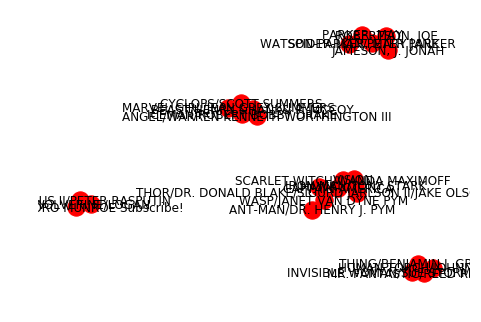

In [32]:
import networkx as nx
import matplotlib.pyplot as plt
G=nx.from_pandas_dataframe(edges, 'Name_1', 'Name_2','weight')

# Plot it
nx.draw(G, with_labels=True)
plt.show()
